## PINNs solution of the 1D Hydrodyanmical Equations with Self-Gravity

Date: 2 March 2023

@author Sayantan Auddy & Ramit Dey

We study Jeans Instability for a fixed wavelength. The code is adoptable and can be modified for other cases as demonstrated in the Paper 

In [1]:
### For Google Colab #### 

# #mount the drive if running from Colab
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install deepxde

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import os

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import scipy
# plt.style.use('ggplot')
## Setting the backend to Tensorflow
dde_backend = tf

## For the FFT solver

from numpy.fft import fft, ifft
from scipy import signal

np.random.seed(1234)
tf.random.set_seed(1234)

Using backend: tensorflow.compat.v1

2023-04-07 11:46:32.970889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 11:46:36.961266: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 11:46:41.850288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-07 11:46:41.851584: W tensorflow/compiler/xla/stream_executo

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




### 1.1 Equations

The hydrostatic system with self-gravity-- 

For an isothermal gas, the dynamics is governed by continuity equation and the momentum equation. They are given as follows,

The mass-continuity equation
$$
\begin{equation}\label{continuity}
    \frac{\partial \rho}{\partial t} + \nabla.(\rho \vec v) =0
\end{equation}\tag{1}
$$
The momentum equation 
$$
\begin{eqnarray}\label{momentum}
\rho \frac{d \vec v}{ d t} = - \nabla P + \rho \vec g \\
\rho \left[\frac{\partial v}{\partial t}+ (\vec v . \nabla)\vec v \right] = - \nabla P + \rho \vec g
\end{eqnarray}\tag{3}
$$
The self-gravity is 
$$
\begin{equation}
\nabla. \vec g = -4\pi G\rho
\end{equation}\tag{3}
$$

where
$$
\begin{equation}\label{poisson}
\nabla^2 \phi =  4 \pi G \rho
\end{equation}\tag{4}
$$
is Poisson's equation and  

$$
\begin{equation}
\nabla \phi =  - \vec g 
\end{equation}\tag{5}
$$

For simplicity, we consider only 1-D. Later we implement 2D and 3D using PINNS.
$$
\begin{eqnarray}
    \frac{\partial \rho_1}{\partial t} + \rho_0 \frac{\partial v_1} {\partial x}  = 0 \\
    \rho_0 \frac{\partial v_1}{\partial t} = - c_s^{2} \frac{\partial \rho_1}{\partial x}  + \rho g_{1} \\
    % P_{1} = \gamma \frac{P_{0}}{\rho_0} \rho_1\\
    \frac{\partial g_1}{\partial x} = - 4 \pi G \rho_1
\end{eqnarray}\tag{6}
$$

#### The initial conditions is derivered using linear analysis (refer to the paper)

$$
\begin{eqnarray}
\rho(x,t=0) &=& \rho_{0} + \rho_{1}\cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{7}
$$

When self-gravity is active and $\lambda> \lambda_{J}$ 

$$
\begin{eqnarray}
v_{x}(x,t=0) &=& -v_{1} \sin\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{8}
$$

where $v_1 = \frac{\alpha}{k} \frac{\rho_1}{\rho}$ and 
$$
\begin{eqnarray}
    \alpha = \sqrt{ 4 \pi G \rho_0 - c_s^2 k^2}
\end{eqnarray}\tag{9}
$$
however for $\lambda < \lambda_{J}$  and for non self-gravitating system 

$$
\begin{eqnarray}
v_{x}(x) &=& v_{1} \cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{10}
$$

#### Considering Periodic Boundary Conditions


$$
\begin{eqnarray}
\rho(x=0,t) &=& \rho (x=xmax,t)\\
v_{x}(x=t,t) &=& v_{x}(x
\end{eqnarray}\tag{11}
$$

<!-- $$
\begin{eqnarray}
=xmax,t)
\end{eqnarray}\tag{12}
$$ -->


### 1.2 Methodology : Using PINNs

The method constructs a neural network approximation. We consider a single neural network with the desired output varibles, $\rho$, $\vec v$ amd $\phi $ - 

$$
\begin{aligned}
\vec v_\theta(t,x), \rho_\theta(t,x), \phi_\theta(t,x) &\approx \mathcal N_{\rho, v}(X;\theta) \\
% \vec v_\theta(t,x) &\approx \mathcal N_{v}(X;\theta_{v})
\end{aligned}\tag{12}
$$

where $X:= (x,t)$, $\theta$ are the parameters for the networks. 

<!-- The idea is to first optimize the network parameters of $\mathcal N_{\rho}(X;\theta_{\rho})$ with those of $\mathcal N_{v}(X;\theta_{v})$ fixed and then vice versa, and the process is iterated until convergennce is achieved. -->

In this approach the total loss can be decoupled as:

The PDE losses associated with Eqs
$$
\begin{eqnarray}
\mathcal L_{\rho} =  \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\partial_t \rho_{\theta}\left(t_i^r, x_i^r\right)+ \partial_x (\rho_{\theta}\left(t_i^r, x_i^r\right) \vec v_{\theta}\left(t_i^r, x_i^r\right)) \right|^2 
\end{eqnarray}\tag{13}
$$
<!-- $$
\begin{eqnarray}
\mathcal L_{\vec v} =  \frac{1}{N_r}\sum_{i=1}^{N_r}\left|\partial_t \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right] + \partial_x \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right]+ c_s^2 \partial_x \rho_{\theta}\left(t_i^r, x_i^r\right)\right|^2
\end{eqnarray}\tag{14}
$$ -->
$$
\begin{eqnarray}
\mathcal L_{\vec v} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\rho_{\theta} \left(t_i^r, x_i^r\right) \partial_t \vec v_{\theta} \left(t_i^r, x_i^r\right)+ \rho_{\theta} \left(t_i^r, x_i^r\right) \vec v_{\theta} \left(t_i^r, x_i^r\right) \partial_x \vec v_{\theta} \left(t_i^r, x_i^r\right) + c_s^2 \partial_x \rho_{\theta} \left(t_i^r, x_i^r\right) + \rho_{\theta} \left(t_i^r, x_i^r\right) \partial_x \phi  \right |^2
\end{eqnarray}\tag{14}
$$

$$
\begin{eqnarray}
\mathcal L_{\vec \phi} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left| \partial_{xx}\phi\left(t_i^r, x_i^r\right) - const* \left(\rho_{\theta}\left(t_i^r, x_i^r\right) - \rho_o\right)   \right |^2
\end{eqnarray} 
$$

where $n$ is the total number of collocation points in the domain denoted by $X$ in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} $

The losses associated with initial and boundary conditions for density $\rho $


$$
    \begin{align*}
   \mathcal L_{\rho_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\rho_{\theta}\left(t_i^0, x_i^0\right) - \rho_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\rho_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\rho_{\theta}\left(t_i^b, x_i^b\right) - \rho_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{15}
$$




The losses associated with initial and boundary conditions for velocity $\vec v_{\theta} $


$$
    \begin{align*}
   \mathcal L_{\vec v_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\vec v_{\theta}\left(t_i^0, x_i^0\right) - \vec v_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\vec  v_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\vec v\left(t_i^b, x_i^b\right) - \vec v_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

<!-- in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\vec v_\theta$ is the neural network approximation of the solution $\vec v\colon[0,T] \times \mathcal{D} \to \mathbb{R}$. -->

The losses associated with  boundary conditions for potential $\phi_{\theta} $

$$
   \begin{align*}   
   \mathcal L_{\phi_0}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b}  \left|\phi_{\theta}\left(t_i^b, x_i^b\right) - \phi_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

$$
   \begin{align*}   
   \mathcal L_{d\phi_0}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b}  \left|d\phi_{\theta}\left(t_i^b, x_i^b\right) - d\phi_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\rho_\theta$ is the neural network approximation of the solution $\rho\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.


In this sequential approach the total loss is decoupled as: 

$$
\begin{eqnarray}
\mathcal L_{\mathcal N_{\rho}} =  \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b} \\ 
\mathcal L_{\mathcal N{\vec v}} =  \mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b} \\
\mathcal L_{\mathcal N_{\phi}} =   \mathcal L_{\phi_b}  + \mathcal L_{d\phi_0}\\ 
\end{eqnarray}\tag{17}
$$

The TOTAL LOSS  

$$
\begin{eqnarray}
\mathcal L_{Total} = \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b}  +\mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b} + \mathcal L_{\vec \phi} + \mathcal L_{\phi_b} +  \mathcal L_{d\phi_0}
\end{eqnarray}
$$

In [3]:
#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
#%matplotlib inline

lam = 7.0           # one wavelength
num_of_wave = 5     # the number of waves
cs = 1.0            # % Sound Speed 
rho_1 = 0.03;       # question 2b non-linear wave propagation
rho_o = 1.0         # zeroth order density
const = 1 # 4.0 * np.pi           # The actual value is 4*pi
G = 1

jeans = np.sqrt(4*np.pi**2*cs**2/(const*G*rho_o))
if lam> jeans:
    alpha = np.sqrt(const*G*rho_o-cs**2*(2*np.pi/lam)**2)
else:
    alpha = np.sqrt(cs**2*(2*np.pi/lam)**2 - const*G*rho_o)
    
# v_1 = (cs*rho_1)/rho_o # velocity perturbation without gravity
v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity

tmax= 3
output_folder = "figures_1D"

try:
    os.makedirs(output_folder)
except OSError:
    print ("Creation of the directory %s failed/ not needed as it already exit" % output_folder)
else:
    print ("Successfully created the directory %s" % output_folder)
  

Successfully created the directory figures_1D


### Network hyperparameters

In [4]:
## General Network Parameters

learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 32 ## 100
activation = "sin" #"tanh"

iterations_adam = 2000

# collocation_points 
precision_train = 100 #200 ## collocation points density
hx_train = lam/ precision_train
nx_train = int(1 / hx_train)*num_of_wave
print("The number of collocation points resolving the domain are = {} and at boundaries are = {}".format(nx_train*nx_train*tmax,50*nx_train))


The number of collocation points resolving the domain are = 14700 and at boundaries are = 3500


## Defining the PINNs 

Compiling model...
Building feed-forward neural network...
'build' took 0.119247 s



/home/sauddy3/PINNS-envcedar/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-04-07 11:46:57.933196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 11:47:02.113545: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-04-07 11:47:02.115716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memor

wavelength 7.0
wavelength 7.0
'compile' took 5.850143 s

Initializing variables...


2023-04-07 11:47:03.704484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Training model...



2023-04-07 11:47:04.468893: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2b68a400e240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-07 11:47:04.469036: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-04-07 11:47:04.763705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-07 11:47:05.822399: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-07 11:47:07.797620: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.53e-02, 8.66e-03, 1.14e+00, 1.03e-03, 1.27e-01, 8.95e-01, 9.95e-04, 8.56e-01, 1.79e-02]    [1.53e-02, 8.66e-03, 1.14e+00, 1.03e-03, 1.27e-01, 8.95e-01, 9.95e-04, 8.56e-01, 1.79e-02]    []  


2023-04-07 11:47:11.851035: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



1000      [1.45e-04, 1.56e-04, 1.38e-04, 1.75e-05, 1.14e-05, 8.10e-07, 2.67e-06, 3.39e-05, 2.27e-05]    [1.45e-04, 1.56e-04, 1.38e-04, 1.75e-05, 1.14e-05, 8.10e-07, 2.67e-06, 3.39e-05, 2.27e-05]    []  
2000      [5.78e-05, 5.16e-05, 4.96e-05, 7.52e-06, 2.88e-06, 1.43e-06, 1.34e-06, 8.23e-06, 1.35e-05]    [5.78e-05, 5.16e-05, 4.96e-05, 7.52e-06, 2.88e-06, 1.43e-06, 1.34e-06, 8.23e-06, 1.35e-05]    []  

Best model at step 2000:
  train loss: 1.94e-04
  test loss: 1.94e-04
  test metric: []

'train' took 17.463844 s

Compiling model...
wavelength 7.0
wavelength 7.0
'compile' took 0.956671 s



2023-04-07 11:47:22.254963: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
2000      [5.78e-05, 5.16e-05, 4.96e-05, 7.52e-06, 2.88e-06, 1.43e-06, 1.34e-06, 8.23e-06, 1.35e-05]    [5.78e-05, 5.16e-05, 4.96e-05, 7.52e-06, 2.88e-06, 1.43e-06, 1.34e-06, 8.23e-06, 1.35e-05]    []  


2023-04-07 11:47:27.232477: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_10'



3000      [3.00e-06, 5.66e-06, 7.22e-06, 5.74e-09, 6.61e-08, 2.54e-08, 4.85e-08, 8.46e-07, 1.06e-06]    [3.00e-06, 5.66e-06, 7.22e-06, 5.74e-09, 6.61e-08, 2.54e-08, 4.85e-08, 8.46e-07, 1.06e-06]        
4000      [2.11e-06, 2.85e-06, 3.13e-06, 1.53e-08, 1.24e-07, 2.07e-08, 7.99e-08, 3.99e-07, 5.11e-07]    [2.11e-06, 2.85e-06, 3.13e-06, 1.53e-08, 1.24e-07, 2.07e-08, 7.99e-08, 3.99e-07, 5.11e-07]        
5000      [1.54e-06, 1.67e-06, 1.22e-06, 6.78e-09, 3.54e-08, 5.80e-09, 1.01e-07, 2.41e-07, 2.74e-07]    [1.54e-06, 1.67e-06, 1.22e-06, 6.78e-09, 3.54e-08, 5.80e-09, 1.01e-07, 2.41e-07, 2.74e-07]        
6000      [1.12e-06, 1.01e-06, 8.20e-07, 3.19e-09, 6.73e-09, 1.68e-08, 1.73e-08, 1.43e-07, 1.52e-07]    [1.12e-06, 1.01e-06, 8.20e-07, 3.19e-09, 6.73e-09, 1.68e-08, 1.73e-08, 1.43e-07, 1.52e-07]        
7000      [6.45e-07, 6.53e-07, 5.89e-07, 1.36e-09, 3.43e-09, 4.60e-09, 1.09e-08, 1.90e-07, 7.15e-08]    [6.45e-07, 6.53e-07, 5.89e-07, 1.36e-09, 3.43e-09, 4.60e-09, 1.09e-08, 1.90e-07, 7.1

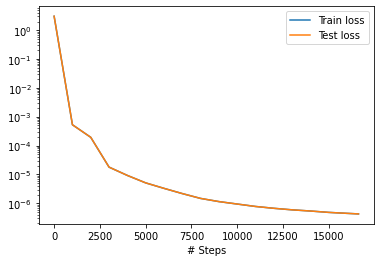

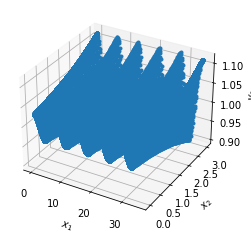

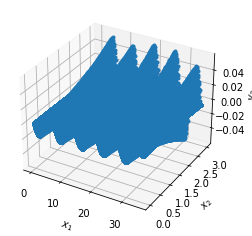

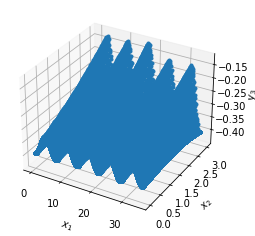

In [5]:
def pdeg(x, y):   

    '''
    The first argument to pde is a 2-dimensional vector where the first component(x[:,0]) is 𝑥
    -coordinate and the second componenet (x[:,1]) is the 𝑡-coordinate.

    The second argument is the network output,is 3-dimensional vector where the first component
    (y[:,0]) is density and the second componenet (y[:,1]) is the velocity amd the third component  (y[:,2])is 
    the gravity in the x direction
    '''
    cs = 1. ## Is the sound speed

    rho, v, phi = y[:,0:1],y[:,1:2],y[:,2:3]
    
    rho_t = dde.grad.jacobian(y, x, i=0, j=1)
    rho_x = dde.grad.jacobian(y, x, i=0, j=0)


    v_t = dde.grad.jacobian(y, x, i=1, j=1)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

   
    phi_x = dde.grad.jacobian(y, x, i=2, j=0)
    phi_xx= dde.grad.hessian(y, x, component=2, i=0, j=0)
    

    rho_r = rho_t + v * rho_x + rho * v_x ## The residue from the density equation
    # v_r = rho_t*v +rho*v_t + rho_x*v*v + rho*v_x*v + rho*v*v_x  +  cs*cs*rho_x +rho*phi_x  ## The residue from the momentum equation
    v_r = rho*v_t + rho*v*v_x + cs*cs*rho_x +rho*phi_x  ### THe momentum equation in 1D-
    
    # g_r = g_x + 4*np.pi*rho 
    phi_r = phi_xx - const*(rho - rho_o) ## The residue from the poisson equation
    
    # lam = 0.5
    # phi_r = phi_xx - (rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam- 2*np.pi*c_s*x[:, 1:2]/lam))
    
    return [rho_r, v_r ,phi_r]

xmin= 0 
xmax= lam*num_of_wave


geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def func(x):
    return 0

def boundary(x, on_boundary):
    return on_boundary

## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here

def boundary_l(x, on_boundary):  # boundary x=-1
    
    if xmin == -1:
        is_on_boundary_left = on_boundary and np.isclose(x[0], -1)
    else:
        is_on_boundary_left = on_boundary and np.isclose(x[0], 0)
    return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)

    return is_on_boundary_right

## Boundary Conditions
bc_rho = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0)
bc_v = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary:on_boundary, component=1)
# bc_g = dde.icbc.boundary_conditions.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary, component=2)


bc_phir=dde.icbc.PeriodicBC(geomtime, 0, boundary_r,component =2) 
bc_phirr = dde.icbc.PeriodicBC(geomtime, 0, boundary_r,derivative_order=1,component =2)

def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam)    
    return rho_0
def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    if lam > jeans:
        v_0 = - v_1 * np.sin(2*np.pi*x[:, 0:1]/lam)## This is for sound wave ## refer to the paper for details
    else:
        v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam)  ## This is for the gravity wave
    return v_0
    

## Initial conditions.
ic_rho = dde.icbc.IC(geomtime,fun_rho_0, lambda _, on_initial: on_initial,component=0)

ic_v = dde.icbc.IC(geomtime,fun_v_0, lambda _, on_initial: on_initial,component=1 )


data = dde.data.TimePDE(geomtime,
                     pdeg,
                    #  [ic_rho,ic_v,bc_rho,bc_v],
                     [bc_rho,bc_v,bc_phir,bc_phirr,ic_rho,ic_v],
                     num_domain=nx_train**2*tmax,   ## Working value 100000,30000,30000
                     num_boundary=50*nx_train,
                     num_initial=50*nx_train,
                    # num_test=10000,
                   )

net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [3], activation, "Glorot normal") ## working config 300*3
model = dde.Model(data, net)


model.compile("adam", lr=1e-3)
model.train(iterations=iterations_adam)
model.compile("L-BFGS")

## When implementing weighted loss
# model.compile("adam", lr=1e-3,loss_weights = [1, 1, 1, 100, 100, 100,100,100])
# model.train(iterations=iterations_adam)
# model.compile("L-BFGS",loss_weights = [1, 1, 1, 100, 100, 100,100,100])

# # Optional: Save the model during training.
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "model/model.ckpt", verbose=1, save_better_only=True
# )
# # Optional: Save the movie of the network solution during training.
# # ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "model/movie.movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
# losshistory, train_state = model.train(iterations=10000, model_save_path = "model1")
# losshistory, train_state = model.train(model_save_path = "./model1/saved_model")

losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [6]:
def plot_function(time_array, velocity = False,isplot =False ,animation=False):
    
    if animation:
        ## Converting the float (time-input) to an numpy array for animation
        ## Ignore this when the function is called in isolation
        time_array = np.array([time_array])
        # print("time",np.asarray(time_array))
    
    rho_max_Pinns = []    
    peak_lst=[]
    pert_xscale=[]
    for t in time_array:
        print("Plotting at t=", t)
        X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
        t_ = t*np.ones(1000).reshape(1000, 1)
        
        X_0 = np.hstack((X, t_))
        
        output_0 = model.predict(X_0)
        
        rho_pred0 = output_0[:,0:1]
        v_pred0 = output_0[:, 1:2]
        phi_pred0=output_0[:, 2:3]
        
        rho_max_PN = np.max(rho_pred0)
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        rho_theory0 = np.max(rho_o + rho_1*np.exp(alpha * 0)*np.cos(2*np.pi*X[:, 0:1]/lam)) ## at t =0 
        
        diff=abs(rho_max_PN-rho_theory)/abs(rho_max_PN+rho_theory) * 2  ## since the den is rhomax+rhotheory

        
        ### Difference between peaks for the PINNs solution
        
        rho_pred0Flat=rho_pred0.reshape(-1)
        peaks,_=scipy.signal.find_peaks(rho_pred0Flat)
        peak_lst.append(peaks)
        
        growth_pert=(rho_theory-rho_theory0)/rho_theory0*100 ## growth percentage
        
        peak_diff=(rho_pred0Flat[peaks[1]]-rho_pred0Flat[peaks[0]])/(rho_pred0Flat[peaks[1]]+rho_pred0Flat[peaks[0]])

        #g_pred0=phi_x = dde.grad.jacobian(phi_pred0, X, i=0, j=0)
        if isplot:              
            print("rho_theory_max={} at time {}".format(rho_theory,t))
            plt.figure(1)
            plt.plot(X,rho_pred0,label="t={}".format(round(t,2)))
            plt.ylabel(r"$\rho$")
            plt.xlabel("x")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.title("Pinns Solution for $\lambda = {}$".format(lam))
            plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
            plt.savefig(output_folder+'/PINNS_density'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            if velocity == True:
              plt.figure(2)
              plt.plot(X,v_pred0,'--',label="t={}".format(round(t,2)))
              plt.ylabel("$v$")
              plt.xlabel("x")
              plt.title("Pinns Solution Velocity")
              plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
              plt.savefig(output_folder+'/PINNS_velocity'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            plt.figure(3)
            plt.plot(X,phi_pred0,'--',label="t={}".format(round(t,2)))
            plt.ylabel(r"$\phi$")
            plt.xlabel("x")
            plt.title("Pinns Solution phi")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.savefig(output_folder+'/phi'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)

            plt.figure(4)
            
            plt.scatter(t,rho_max_PN)
            plt.plot(t,rho_theory,marker='^',label="LT")
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)
    #         plt.axhline(rho_theory , color = 'r', linestyle = '--')
            plt.xlabel("t")
            plt.ylabel(r"$\rho_{\rm max}$")
            plt.savefig(output_folder+'/rho_max'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            
            plt.figure(6)
            plt.scatter(growth_pert,peak_diff*100)
            plt.ylabel("peak difference $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('DIF bet 1st and central peak')
            plt.savefig(output_folder+'/gwt2'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            plt.figure(7)
            plt.scatter(growth_pert,diff*100)
            plt.ylabel("rel DIF-FD-PINN $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('relative DIF-FD-PINN')
            plt.savefig(output_folder+'/gwt1'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
        
        else:  
            if animation:
                return X ,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory
            else:
                return X ,rho_pred0,rho_max_PN,rho_theory 


#         plt.show()




Plotting at t= 0.0
rho_theory_max=1.03 at time 0.0
Plotting at t= 0.6
rho_theory_max=1.0390829566070539 at time 0.6
Plotting at t= 1.2
rho_theory_max=1.0509159165716286 at time 1.2
Plotting at t= 1.7999999999999998
rho_theory_max=1.0663314852659114 at time 1.7999999999999998
Plotting at t= 2.4
rho_theory_max=1.0864143520109684 at time 2.4
Plotting at t= 3.0
rho_theory_max=1.1125776123290454 at time 3.0


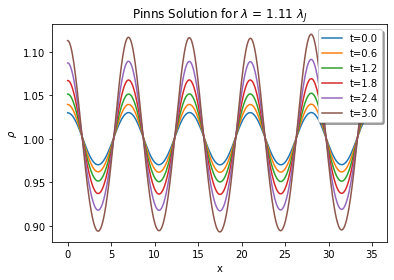

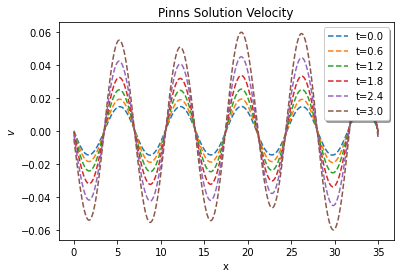

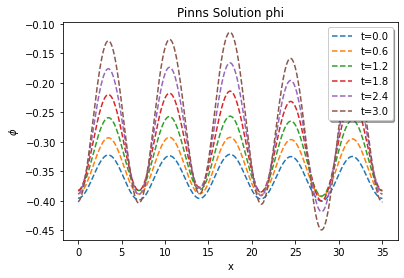

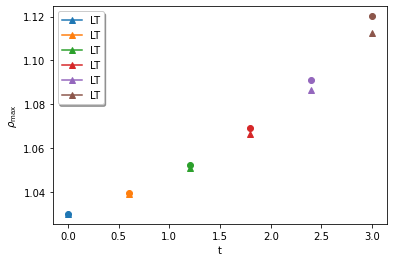

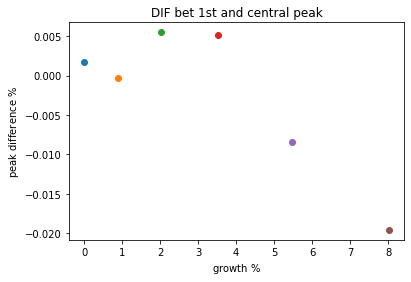

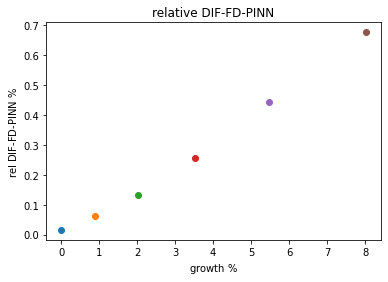

In [7]:
# import hydro_function as PF
# time_array = [0.0,1,2,3,4,5,6,7,8] 
time_array = np.linspace(0,tmax,tmax+3)
# time_array = np.linspace(0,1,4)
plot_function(time_array,velocity=True,isplot =True)


## To Animate the PINNs Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as anim
from pathlib import Path
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
plt.style.use('ggplot')

## Time and Space Array
t = np.linspace(0,tmax,100)
# X = np.linspace(xmin,xmax,N).reshape(N, 1)
numDataPoints = len(t)


# # Initialize plot

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches(8,8)


def animate_func(num):
    ax1.clear()  # Clears the figure to update the line, point,   
    ax2.clear()  
    ax3.clear()  # Clears the figure to update the line, point
    # ax4.clear()  # Clears the figure to update the line, point
    
    # t_ = t[num+1]*np.ones(1000).reshape(1000, 1)
    t0 = t[0]*np.ones(1000).reshape(1000, 1)

    
    X ,rho_pred0,v_pred0,phi_pred0,rho_max,rho_theory =  plot_function(t[num],velocity=True,isplot = False, animation=True)
    X_intial = np.hstack((X,t0))
    intial_output = model.predict(X_intial)
    
    lim_y_b = rho_o - rho_1*10  ## To fix the axes ylim auto
    lim_y_u = rho_o + rho_1*10
    
    ax1.plot(X, rho_pred0, "-", color = "C3", lw = 2,label="t={}".format(round(t[num+1],3)))
    ax1.plot(X, intial_output[:,0:1], "--", color = "C3", lw = 2,label=" t= 0")
    ax1.set_ylabel(r"$\rho$")
    ax1.set_ylim([lim_y_b,lim_y_u ])
    ax1.set_xlabel("x")
    
    # rho,v ,n = lax_solution_animate(t[num+1],N,rho_1 = rho_1,velocity=False)
    # ax1.plot(X,rho[n-1,:],linewidth=1,label="lax-Sol")
    ax1.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)



    ax3.plot(X,v_pred0,label=" t={}".format(round(t[num+1],3)))
    ax3.set_ylabel("$v$")
    ax3.set_ylim([-0.5,0.5 ])
    ax3.set_xlabel("x")
    
    # ax2.plot(X,v[n-1,:],linewidth=1,label="lax-Sol")
    ax3.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
    
    ax2.plot(X,phi_pred0,'--',label="PINNS at t={}".format(round(t[num+1],3)))
    ax2.set_ylabel("$\phi$")
    ax2.set_xlabel("x")
    ax2.set_ylim([-1.3,.6])
    
    rho_max = np.max(rho_pred0)
        # print(rho_max)
    ax4.scatter(t[num],rho_max,c = 'red')
    ax4.set_ylim([1,lim_y_u])
    ax4.set_xlim([0,tmax+0.5])
    ax4.set_xlabel("t")
    ax4.set_ylabel(r"$\rho_{\rm max}$")
    plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
    plt.tight_layout()



line_ani = FuncAnimation(fig, animate_func, interval=30,   
                                   frames=numDataPoints-1)
  
### saving to m4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=20)
# line_ani.save('instability_'+str(lam)+ '.mp4', writer=writervideo)
ax4.clear()  # Clears the figure to update the line, point
line_ani.save(output_folder+'/instability_'+str(lam)+ '.gif', writer='pillow', fps=60)
plt.close()
plt.show()
print("[INFO]: Animation is complete")

Plotting at t= 0.0
Plotting at t= 0.0
Plotting at t= 0.030303030303030304
Plotting at t= 0.06060606060606061
Plotting at t= 0.09090909090909091
Plotting at t= 0.12121212121212122
Plotting at t= 0.15151515151515152
Plotting at t= 0.18181818181818182
Plotting at t= 0.21212121212121213
Plotting at t= 0.24242424242424243
Plotting at t= 0.2727272727272727
Plotting at t= 0.30303030303030304
Plotting at t= 0.33333333333333337
Plotting at t= 0.36363636363636365
Plotting at t= 0.3939393939393939
Plotting at t= 0.42424242424242425
Plotting at t= 0.4545454545454546
Plotting at t= 0.48484848484848486
Plotting at t= 0.5151515151515151
Plotting at t= 0.5454545454545454
Plotting at t= 0.5757575757575758
Plotting at t= 0.6060606060606061
Plotting at t= 0.6363636363636364
Plotting at t= 0.6666666666666667
Plotting at t= 0.696969696969697
Plotting at t= 0.7272727272727273
Plotting at t= 0.7575757575757576
Plotting at t= 0.7878787878787878
Plotting at t= 0.8181818181818182
Plotting at t= 0.84848484848484